In [ ]:
# Multiclass Semantic Segmentation using CamVid dataset

In [ ]:
## Introduction
# - Semantic Segmentation of an image is to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification.
# - A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network. - - The encoder is usually is a pre-trained classification network like VGG/ResNet followed by a decoder network. The decoder network/mechanism is mostly where these architectures differ. 
# - The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. (mechanisms like skip connections, pyramid pooling etc are used for this)



In [ ]:
## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
print(tf.__version__)

2.0.0


In [3]:
# Environment checks

In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
False
Is the Tensor on GPU #0:  
False
Device name: /job:localhost/replica:0/task:0/device:CPU:0


In [5]:
print(tf.executing_eagerly())

True


In [6]:
## Data preparation - Importing, Cleaning and Creating structured directory 

In [7]:
### Function to import and process frames and masks as tensors

In [2]:
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

In [9]:
### Image directory and size parameters

In [3]:
data_dir = './PycharmProjects/COMPVIZDATASET/'
if not os.path.exists(data_dir):
    print("PLEASE CHANGE THE IMAGE DIRECTORY")
    exit(1)
else:
    print("File path exists")
# Required image dimensions
output_height = 256
output_width = 256

File path exists


In [13]:
# ### Reading frames and masks
# - Mask file names end in "\_L.png"


In [4]:
def read_images(data_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    print(data_dir)
    frames_dir = os.path.join(data_dir,"Dataset")
    labels_dir = os.path.join(data_dir,"Labels")
    
    # Get the file names list from provided directory
    frames_list = [f for f in os.listdir(frames_dir) if os.path.isfile(os.path.join(frames_dir, f))]
    labels_list = [f for f in os.listdir(labels_dir) if os.path.isfile(os.path.join(labels_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in frames_list]
    masks_list = [file for file in labels_list]
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(frames_dir, fname) for fname in frames_list]
    frames_paths.sort()
    masks_paths = [os.path.join(labels_dir, fname) for fname in masks_list]
    masks_paths.sort()
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

frame_tensors, masks_tensors, frames_list, masks_list = read_images(data_dir)

./PycharmProjects/COMPVIZDATASET/


101 frame files found in the provided directory.
101 mask files found in the provided directory.


Completed importing 101 frame images from the provided directory.
Completed importing 101 mask images from the provided directory.


In [14]:
### Displaying Images in the train dataset

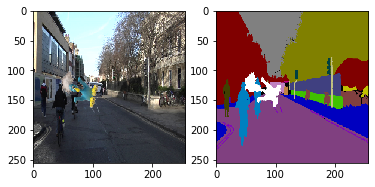

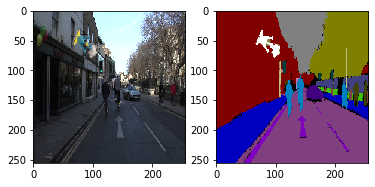

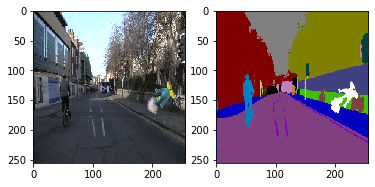

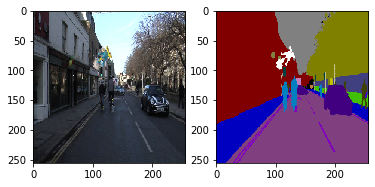

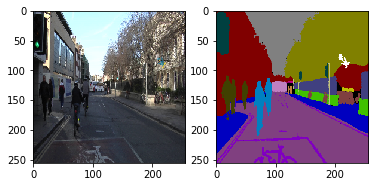

In [5]:
# Make an iterator to extract images from the tensor dataset
frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [16]:
### Creating folder structure common for Computer Vision problems

In [6]:
DATA_PATH = 'data/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[Errno 17] File exists: 'data/CamSeq01/train_frames/train'
[Errno 17] File exists: 'data/CamSeq01/train_masks/train'
[Errno 17] File exists: 'data/CamSeq01/val_frames/val'
[Errno 17] File exists: 'data/CamSeq01/val_masks/val'


In [60]:
### Saving frames and masks to correct directories

In [7]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 101 frames to directory data/CamSeq01/
Saved 101 masks to directory data/CamSeq01/


In [62]:
## Extract Target Class definitions

In [63]:
### Function to parse the file "label_colors.txt" which contains the class definitions

In [8]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [65]:
### Parse and extract label names and codes

In [9]:
label_codes, label_names = zip(*[parse_code(l) for l in open(data_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (255, 255, 255), (0, 128, 64)],
 ['Animal', 'Archway', 'Bicyclist', 'Bird', 'Bridge'])

In [10]:
label_codes, label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (255, 255, 255),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bird',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',

In [11]:
# ### Create useful label and code conversion dictionaries
# _These will be used for:_
# - One hot encoding the mask labels for model training
# - Decoding the predicted labels for interpretation and visualization

In [12]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [13]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [14]:
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (255, 255, 255),
 4: (0, 128, 64),
 5: (128, 0, 0),
 6: (64, 0, 128),
 7: (64, 0, 192),
 8: (192, 128, 64),
 9: (192, 192, 128),
 10: (64, 64, 128),
 11: (128, 0, 192),
 12: (192, 0, 64),
 13: (128, 128, 64),
 14: (192, 0, 192),
 15: (128, 64, 64),
 16: (64, 192, 128),
 17: (64, 64, 0),
 18: (128, 64, 128),
 19: (128, 128, 192),
 20: (0, 0, 192),
 21: (192, 128, 128),
 22: (128, 128, 128),
 23: (64, 128, 192),
 24: (0, 0, 64),
 25: (0, 64, 64),
 26: (192, 64, 128),
 27: (128, 128, 0),
 28: (192, 128, 192),
 29: (64, 0, 64),
 30: (192, 192, 0),
 31: (0, 0, 0),
 32: (64, 192, 0)}

In [15]:
id2name

{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bird',
 4: 'Bridge',
 5: 'Building',
 6: 'Car',
 7: 'CartLuggagePram',
 8: 'Child',
 9: 'Column_Pole',
 10: 'Fence',
 11: 'LaneMkgsDriv',
 12: 'LaneMkgsNonDriv',
 13: 'Misc_Text',
 14: 'MotorcycleScooter',
 15: 'OtherMoving',
 16: 'ParkingBlock',
 17: 'Pedestrian',
 18: 'Road',
 19: 'RoadShoulder',
 20: 'Sidewalk',
 21: 'SignSymbol',
 22: 'Sky',
 23: 'SUVPickupTruck',
 24: 'TrafficCone',
 25: 'TrafficLight',
 26: 'Train',
 27: 'Tree',
 28: 'Truck_Bus',
 29: 'Tunnel',
 30: 'VegetationMisc',
 31: 'Void',
 32: 'Wall'}

In [16]:
### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [17]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [18]:
# Creating custom Image data generators

In [19]:
### Defining data generators

In [20]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [21]:
### Custom image data generators for creating batches of frames and masks

In [22]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        


In [23]:
# Defining U-Net model for semantic segmentation
# <b>U-Net Architecture</b>
# 
# <div style="text-align: center;">
#         
#         <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="U-Net" height="600" width="800">
# </div>
# 
# [Picture Credits](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)<br><br>


In [24]:
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(5, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(33, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [25]:
## Generating U-Net model 

In [26]:
model = get_small_unet(n_filters = 33)

Tensor("input_1:0", shape=(5, 256, 256, 3), dtype=float32)


In [85]:
## Defining dice co-efficients for model performance

In [27]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [29]:
smooth = 1.

In [89]:
# ## Compiling model
# - Using categorical crossentropy loss since labels have been one hot encoded

In [30]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,'accuracy'])


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(5, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (5, 256, 256, 33)    924         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (5, 256, 256, 33)    132         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (5, 256, 256, 33)    9834        batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
model.load_weights("camvid_model_150_epochs_checkpoint.h5")

In [33]:
## Define model callback settings

In [34]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_150_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
callbacks = [tb, mc, es]

In [35]:
## Train and save the U-Net model

In [36]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(frames_list) - round(0.1*len(frames_list))) / float(batch_size))
steps_per_epoch

19.0

In [37]:
validation_steps = (float((round(0.1*len(frames_list)))) / float(batch_size))
validation_steps

2.0

In [40]:
num_epochs = 20

In [41]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=18 ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks)
model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

Found 81 images belonging to 1 classes.


Found 81 images belonging to 1 classes.


Epoch 1/20


 1/18 [>.............................] - ETA: 12:23 - loss: 0.3624 - tversky_loss: 32.1873 - dice_coef: 0.8915 - accuracy: 0.8525

 2/18 [==>...........................] - ETA: 7:08 - loss: 0.4022 - tversky_loss: 32.1918 - dice_coef: 0.8828 - accuracy: 0.8420 

 3/18 [====>.........................] - ETA: 5:11 - loss: 0.3756 - tversky_loss: 32.1860 - dice_coef: 0.8885 - accuracy: 0.8483

 4/18 [=====>........................] - ETA: 4:10 - loss: 0.3671 - tversky_loss: 32.1848 - dice_coef: 0.8904 - accuracy: 0.8504

 5/18 [=======>......................] - ETA: 3:29 - loss: 0.3581 - tversky_loss: 32.1835 - dice_coef: 0.8924 - accuracy: 0.8527

 6/18 [=========>....................] - ETA: 2:58 - loss: 0.3480 - tversky_loss: 32.1810 - dice_coef: 0.8955 - accuracy: 0.8561

 7/18 [==========>...................] - ETA: 2:34 - loss: 0.3443 - tversky_loss: 32.1797 - dice_coef: 0.8968 - accuracy: 0.8578

 8/18 [============>.................] - ETA: 2:13 - loss: 0.3381 - tversky_loss: 32.1782 - dice_coef: 0.8984 - accuracy: 0.8596

 9/18 [==============>...............] - ETA: 1:55 - loss: 0.3323 - tversky_loss: 32.1765 - dice_coef: 0.9004 - accuracy: 0.8618

10/18 [===============>..............] - ETA: 1:39 - loss: 0.3283 - tversky_loss: 32.1755 - dice_coef: 0.9016 - accuracy: 0.8636

11/18 [=================>............] - ETA: 1:24 - loss: 0.3276 - tversky_loss: 32.1759 - dice_coef: 0.9015 - accuracy: 0.8635

12/18 [===================>..........] - ETA: 1:11 - loss: 0.3308 - tversky_loss: 32.1770 - dice_coef: 0.9006 - accuracy: 0.8622

13/18 [====================>.........] - ETA: 1:00 - loss: 0.3288 - tversky_loss: 32.1763 - dice_coef: 0.9010 - accuracy: 0.8626

14/18 [======================>.......] - ETA: 48s - loss: 0.3277 - tversky_loss: 32.1763 - dice_coef: 0.9011 - accuracy: 0.8627 

15/18 [========================>.....] - ETA: 36s - loss: 0.3261 - tversky_loss: 32.1756 - dice_coef: 0.9018 - accuracy: 0.8636

16/18 [=========================>....] - ETA: 24s - loss: 0.3215 - tversky_loss: 32.1736 - dice_coef: 0.9032 - accuracy: 0.8652

17/18 [===========================>..] - ETA: 11s - loss: 0.3182 - tversky_loss: 32.1723 - dice_coef: 0.9042 - accuracy: 0.8654

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.



Epoch 00001: accuracy improved from -inf to 0.86628, saving model to camvid_model_150_epochs_checkpoint.h5


18/18 [==============================] - 219s 12s/step - loss: 0.3160 - tversky_loss: 32.1713 - dice_coef: 0.9050 - accuracy: 0.8663 - val_loss: 1.7214 - val_tversky_loss: 32.3708 - val_dice_coef: 0.6897 - val_accuracy: 0.6587


Epoch 2/20


 1/18 [>.............................] - ETA: 8:26 - loss: 0.2648 - tversky_loss: 32.1508 - dice_coef: 0.9195 - accuracy: 0.8858

 2/18 [==>...........................] - ETA: 5:15 - loss: 0.2712 - tversky_loss: 32.1548 - dice_coef: 0.9170 - accuracy: 0.8816

 3/18 [====>.........................] - ETA: 4:03 - loss: 0.2699 - tversky_loss: 32.1556 - dice_coef: 0.9169 - accuracy: 0.8821

 4/18 [=====>........................] - ETA: 3:23 - loss: 0.2680 - tversky_loss: 32.1527 - dice_coef: 0.9184 - accuracy: 0.8838

 5/18 [=======>......................] - ETA: 2:54 - loss: 0.2648 - tversky_loss: 32.1520 - dice_coef: 0.9190 - accuracy: 0.8845

 6/18 [=========>....................] - ETA: 2:32 - loss: 0.2631 - tversky_loss: 32.1512 - dice_coef: 0.9192 - accuracy: 0.8847

 7/18 [==========>...................] - ETA: 2:15 - loss: 0.2661 - tversky_loss: 32.1516 - dice_coef: 0.9184 - accuracy: 0.8835

 8/18 [============>.................] - ETA: 1:59 - loss: 0.2681 - tversky_loss: 32.1523 - dice_coef: 0.9178 - accuracy: 0.8828

 9/18 [==============>...............] - ETA: 1:48 - loss: 0.2691 - tversky_loss: 32.1528 - dice_coef: 0.9174 - accuracy: 0.8823

10/18 [===============>..............] - ETA: 1:33 - loss: 0.2683 - tversky_loss: 32.1525 - dice_coef: 0.9175 - accuracy: 0.8823

11/18 [=================>............] - ETA: 1:20 - loss: 0.2672 - tversky_loss: 32.1517 - dice_coef: 0.9181 - accuracy: 0.8830

12/18 [===================>..........] - ETA: 1:08 - loss: 0.2650 - tversky_loss: 32.1511 - dice_coef: 0.9187 - accuracy: 0.8840

13/18 [====================>.........] - ETA: 58s - loss: 0.2639 - tversky_loss: 32.1505 - dice_coef: 0.9190 - accuracy: 0.8843 

14/18 [======================>.......] - ETA: 47s - loss: 0.2621 - tversky_loss: 32.1502 - dice_coef: 0.9196 - accuracy: 0.8850

15/18 [========================>.....] - ETA: 35s - loss: 0.2624 - tversky_loss: 32.1501 - dice_coef: 0.9196 - accuracy: 0.8850

16/18 [=========================>....] - ETA: 22s - loss: 0.2618 - tversky_loss: 32.1493 - dice_coef: 0.9199 - accuracy: 0.8851

17/18 [===========================>..] - ETA: 11s - loss: 0.2597 - tversky_loss: 32.1483 - dice_coef: 0.9206 - accuracy: 0.8859


Epoch 00002: accuracy improved from 0.86628 to 0.88601, saving model to camvid_model_150_epochs_checkpoint.h5


18/18 [==============================] - 211s 12s/step - loss: 0.2589 - tversky_loss: 32.1481 - dice_coef: 0.9207 - accuracy: 0.8860 - val_loss: 1.4676 - val_tversky_loss: 32.3245 - val_dice_coef: 0.7296 - val_accuracy: 0.6951


Epoch 3/20


 1/18 [>.............................] - ETA: 2:52 - loss: 0.2778 - tversky_loss: 32.1470 - dice_coef: 0.9180 - accuracy: 0.8849

 2/18 [==>...........................] - ETA: 2:41 - loss: 0.2619 - tversky_loss: 32.1424 - dice_coef: 0.9211 - accuracy: 0.8875

 3/18 [====>.........................] - ETA: 2:29 - loss: 0.2562 - tversky_loss: 32.1420 - dice_coef: 0.9224 - accuracy: 0.8890

 4/18 [=====>........................] - ETA: 2:17 - loss: 0.2676 - tversky_loss: 32.1446 - dice_coef: 0.9189 - accuracy: 0.8844

 5/18 [=======>......................] - ETA: 2:06 - loss: 0.2651 - tversky_loss: 32.1454 - dice_coef: 0.9189 - accuracy: 0.8839

 6/18 [=========>....................] - ETA: 1:56 - loss: 0.2611 - tversky_loss: 32.1440 - dice_coef: 0.9199 - accuracy: 0.8849

 7/18 [==========>...................] - ETA: 1:45 - loss: 0.2575 - tversky_loss: 32.1433 - dice_coef: 0.9207 - accuracy: 0.8860

 8/18 [============>.................] - ETA: 1:35 - loss: 0.2597 - tversky_loss: 32.1444 - dice_coef: 0.9200 - accuracy: 0.8852

 9/18 [==============>...............] - ETA: 1:24 - loss: 0.2560 - tversky_loss: 32.1437 - dice_coef: 0.9212 - accuracy: 0.8868

10/18 [===============>..............] - ETA: 1:14 - loss: 0.2542 - tversky_loss: 32.1441 - dice_coef: 0.9217 - accuracy: 0.8878

11/18 [=================>............] - ETA: 1:05 - loss: 0.2529 - tversky_loss: 32.1438 - dice_coef: 0.9222 - accuracy: 0.8886

12/18 [===================>..........] - ETA: 55s - loss: 0.2524 - tversky_loss: 32.1436 - dice_coef: 0.9223 - accuracy: 0.8887 

13/18 [====================>.........] - ETA: 46s - loss: 0.2523 - tversky_loss: 32.1435 - dice_coef: 0.9223 - accuracy: 0.8886

14/18 [======================>.......] - ETA: 36s - loss: 0.2512 - tversky_loss: 32.1430 - dice_coef: 0.9226 - accuracy: 0.8888

15/18 [========================>.....] - ETA: 26s - loss: 0.2535 - tversky_loss: 32.1429 - dice_coef: 0.9224 - accuracy: 0.8887

16/18 [=========================>....] - ETA: 18s - loss: 0.2529 - tversky_loss: 32.1425 - dice_coef: 0.9226 - accuracy: 0.8889

17/18 [===========================>..] - ETA: 9s - loss: 0.2510 - tversky_loss: 32.1418 - dice_coef: 0.9232 - accuracy: 0.8895 


Epoch 00003: accuracy improved from 0.88601 to 0.88914, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 180s 10s/step - loss: 0.2511 - tversky_loss: 32.1418 - dice_coef: 0.9230 - accuracy: 0.8891 - val_loss: 1.6889 - val_tversky_loss: 32.3333 - val_dice_coef: 0.7135 - val_accuracy: 0.6821


Epoch 4/20


 1/18 [>.............................] - ETA: 3:39 - loss: 0.2456 - tversky_loss: 32.1398 - dice_coef: 0.9227 - accuracy: 0.8866

 2/18 [==>...........................] - ETA: 3:10 - loss: 0.2509 - tversky_loss: 32.1367 - dice_coef: 0.9233 - accuracy: 0.8895

 3/18 [====>.........................] - ETA: 2:51 - loss: 0.2457 - tversky_loss: 32.1334 - dice_coef: 0.9252 - accuracy: 0.8912

 4/18 [=====>........................] - ETA: 2:35 - loss: 0.2436 - tversky_loss: 32.1336 - dice_coef: 0.9254 - accuracy: 0.8917

 5/18 [=======>......................] - ETA: 2:21 - loss: 0.2397 - tversky_loss: 32.1328 - dice_coef: 0.9267 - accuracy: 0.8937

 6/18 [=========>....................] - ETA: 2:08 - loss: 0.2352 - tversky_loss: 32.1314 - dice_coef: 0.9280 - accuracy: 0.8957

 7/18 [==========>...................] - ETA: 1:55 - loss: 0.2331 - tversky_loss: 32.1310 - dice_coef: 0.9285 - accuracy: 0.8960

 8/18 [============>.................] - ETA: 1:43 - loss: 0.2371 - tversky_loss: 32.1335 - dice_coef: 0.9268 - accuracy: 0.8936

 9/18 [==============>...............] - ETA: 1:32 - loss: 0.2358 - tversky_loss: 32.1338 - dice_coef: 0.9270 - accuracy: 0.8939

10/18 [===============>..............] - ETA: 1:21 - loss: 0.2363 - tversky_loss: 32.1349 - dice_coef: 0.9267 - accuracy: 0.8933

11/18 [=================>............] - ETA: 1:10 - loss: 0.2371 - tversky_loss: 32.1350 - dice_coef: 0.9266 - accuracy: 0.8931

12/18 [===================>..........] - ETA: 59s - loss: 0.2364 - tversky_loss: 32.1351 - dice_coef: 0.9267 - accuracy: 0.8932 

13/18 [====================>.........] - ETA: 49s - loss: 0.2372 - tversky_loss: 32.1356 - dice_coef: 0.9264 - accuracy: 0.8928

14/18 [======================>.......] - ETA: 37s - loss: 0.2418 - tversky_loss: 32.1374 - dice_coef: 0.9248 - accuracy: 0.8924

15/18 [========================>.....] - ETA: 27s - loss: 0.2395 - tversky_loss: 32.1367 - dice_coef: 0.9255 - accuracy: 0.8932

16/18 [=========================>....] - ETA: 18s - loss: 0.2394 - tversky_loss: 32.1365 - dice_coef: 0.9256 - accuracy: 0.8931

17/18 [===========================>..] - ETA: 9s - loss: 0.2421 - tversky_loss: 32.1372 - dice_coef: 0.9249 - accuracy: 0.8921 


Epoch 00004: accuracy improved from 0.88914 to 0.89149, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 176s 10s/step - loss: 0.2436 - tversky_loss: 32.1377 - dice_coef: 0.9244 - accuracy: 0.8915 - val_loss: 1.8930 - val_tversky_loss: 32.3943 - val_dice_coef: 0.6580 - val_accuracy: 0.6188


Epoch 5/20


 1/18 [>.............................] - ETA: 3:51 - loss: 0.2445 - tversky_loss: 32.1388 - dice_coef: 0.9237 - accuracy: 0.8885

 2/18 [==>...........................] - ETA: 3:29 - loss: 0.2391 - tversky_loss: 32.1387 - dice_coef: 0.9251 - accuracy: 0.8911

 3/18 [====>.........................] - ETA: 3:10 - loss: 0.2367 - tversky_loss: 32.1366 - dice_coef: 0.9264 - accuracy: 0.8927

 4/18 [=====>........................] - ETA: 2:52 - loss: 0.2414 - tversky_loss: 32.1385 - dice_coef: 0.9249 - accuracy: 0.8906

 5/18 [=======>......................] - ETA: 2:35 - loss: 0.2470 - tversky_loss: 32.1417 - dice_coef: 0.9231 - accuracy: 0.8886

 6/18 [=========>....................] - ETA: 2:20 - loss: 0.2414 - tversky_loss: 32.1405 - dice_coef: 0.9249 - accuracy: 0.8911

 7/18 [==========>...................] - ETA: 2:06 - loss: 0.2377 - tversky_loss: 32.1391 - dice_coef: 0.9261 - accuracy: 0.8926

 8/18 [============>.................] - ETA: 1:52 - loss: 0.2397 - tversky_loss: 32.1406 - dice_coef: 0.9253 - accuracy: 0.8914

 9/18 [==============>...............] - ETA: 1:39 - loss: 0.2460 - tversky_loss: 32.1418 - dice_coef: 0.9238 - accuracy: 0.8894

10/18 [===============>..............] - ETA: 1:27 - loss: 0.2452 - tversky_loss: 32.1419 - dice_coef: 0.9238 - accuracy: 0.8894

11/18 [=================>............] - ETA: 1:15 - loss: 0.2422 - tversky_loss: 32.1405 - dice_coef: 0.9248 - accuracy: 0.8907

12/18 [===================>..........] - ETA: 1:03 - loss: 0.2430 - tversky_loss: 32.1401 - dice_coef: 0.9248 - accuracy: 0.8905

13/18 [====================>.........] - ETA: 49s - loss: 0.2398 - tversky_loss: 32.1384 - dice_coef: 0.9256 - accuracy: 0.8907 

14/18 [======================>.......] - ETA: 39s - loss: 0.2383 - tversky_loss: 32.1376 - dice_coef: 0.9260 - accuracy: 0.8911

15/18 [========================>.....] - ETA: 29s - loss: 0.2383 - tversky_loss: 32.1374 - dice_coef: 0.9260 - accuracy: 0.8911

16/18 [=========================>....] - ETA: 19s - loss: 0.2375 - tversky_loss: 32.1371 - dice_coef: 0.9261 - accuracy: 0.8912

17/18 [===========================>..] - ETA: 9s - loss: 0.2391 - tversky_loss: 32.1375 - dice_coef: 0.9256 - accuracy: 0.8908 


Epoch 00005: accuracy improved from 0.89149 to 0.89171, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 180s 10s/step - loss: 0.2376 - tversky_loss: 32.1369 - dice_coef: 0.9261 - accuracy: 0.8917 - val_loss: 1.5418 - val_tversky_loss: 32.3425 - val_dice_coef: 0.7136 - val_accuracy: 0.6767


Epoch 6/20


 1/18 [>.............................] - ETA: 2:28 - loss: 0.2390 - tversky_loss: 32.1380 - dice_coef: 0.9243 - accuracy: 0.8902

 2/18 [==>...........................] - ETA: 2:22 - loss: 0.2360 - tversky_loss: 32.1341 - dice_coef: 0.9272 - accuracy: 0.8936

 3/18 [====>.........................] - ETA: 2:28 - loss: 0.2384 - tversky_loss: 32.1360 - dice_coef: 0.9264 - accuracy: 0.8926

 4/18 [=====>........................] - ETA: 2:33 - loss: 0.2331 - tversky_loss: 32.1342 - dice_coef: 0.9281 - accuracy: 0.8943

 5/18 [=======>......................] - ETA: 2:28 - loss: 0.2315 - tversky_loss: 32.1334 - dice_coef: 0.9281 - accuracy: 0.8943

 6/18 [=========>....................] - ETA: 2:19 - loss: 0.2308 - tversky_loss: 32.1331 - dice_coef: 0.9280 - accuracy: 0.8940

 7/18 [==========>...................] - ETA: 2:07 - loss: 0.2284 - tversky_loss: 32.1323 - dice_coef: 0.9289 - accuracy: 0.8948

 8/18 [============>.................] - ETA: 1:55 - loss: 0.2295 - tversky_loss: 32.1328 - dice_coef: 0.9285 - accuracy: 0.8942

 9/18 [==============>...............] - ETA: 1:43 - loss: 0.2306 - tversky_loss: 32.1330 - dice_coef: 0.9282 - accuracy: 0.8939

10/18 [===============>..............] - ETA: 1:30 - loss: 0.2333 - tversky_loss: 32.1347 - dice_coef: 0.9273 - accuracy: 0.8929

11/18 [=================>............] - ETA: 1:18 - loss: 0.2323 - tversky_loss: 32.1341 - dice_coef: 0.9277 - accuracy: 0.8936

12/18 [===================>..........] - ETA: 1:02 - loss: 0.2386 - tversky_loss: 32.1370 - dice_coef: 0.9252 - accuracy: 0.8929

13/18 [====================>.........] - ETA: 52s - loss: 0.2389 - tversky_loss: 32.1372 - dice_coef: 0.9248 - accuracy: 0.8921 

14/18 [======================>.......] - ETA: 41s - loss: 0.2364 - tversky_loss: 32.1364 - dice_coef: 0.9256 - accuracy: 0.8931

15/18 [========================>.....] - ETA: 30s - loss: 0.2350 - tversky_loss: 32.1357 - dice_coef: 0.9260 - accuracy: 0.8936

16/18 [=========================>....] - ETA: 20s - loss: 0.2341 - tversky_loss: 32.1356 - dice_coef: 0.9263 - accuracy: 0.8940

17/18 [===========================>..] - ETA: 10s - loss: 0.2340 - tversky_loss: 32.1354 - dice_coef: 0.9265 - accuracy: 0.8943


Epoch 00006: accuracy improved from 0.89171 to 0.89437, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 188s 10s/step - loss: 0.2333 - tversky_loss: 32.1351 - dice_coef: 0.9267 - accuracy: 0.8944 - val_loss: 1.7464 - val_tversky_loss: 32.3640 - val_dice_coef: 0.6922 - val_accuracy: 0.6591


Epoch 7/20


 1/18 [>.............................] - ETA: 2:34 - loss: 0.2382 - tversky_loss: 32.1412 - dice_coef: 0.9234 - accuracy: 0.8867

 2/18 [==>...........................] - ETA: 2:22 - loss: 0.2375 - tversky_loss: 32.1346 - dice_coef: 0.9255 - accuracy: 0.8909

 3/18 [====>.........................] - ETA: 2:12 - loss: 0.2269 - tversky_loss: 32.1296 - dice_coef: 0.9291 - accuracy: 0.8951

 4/18 [=====>........................] - ETA: 2:03 - loss: 0.2219 - tversky_loss: 32.1272 - dice_coef: 0.9308 - accuracy: 0.8971

 5/18 [=======>......................] - ETA: 1:56 - loss: 0.2224 - tversky_loss: 32.1264 - dice_coef: 0.9307 - accuracy: 0.8972

 6/18 [=========>....................] - ETA: 1:56 - loss: 0.2250 - tversky_loss: 32.1271 - dice_coef: 0.9297 - accuracy: 0.8962

 7/18 [==========>...................] - ETA: 1:53 - loss: 0.2258 - tversky_loss: 32.1275 - dice_coef: 0.9296 - accuracy: 0.8959

 8/18 [============>.................] - ETA: 1:46 - loss: 0.2300 - tversky_loss: 32.1295 - dice_coef: 0.9282 - accuracy: 0.8944

 9/18 [==============>...............] - ETA: 1:37 - loss: 0.2325 - tversky_loss: 32.1308 - dice_coef: 0.9275 - accuracy: 0.8935

10/18 [===============>..............] - ETA: 1:26 - loss: 0.2344 - tversky_loss: 32.1321 - dice_coef: 0.9268 - accuracy: 0.8923

11/18 [=================>............] - ETA: 1:10 - loss: 0.2341 - tversky_loss: 32.1325 - dice_coef: 0.9272 - accuracy: 0.8926

12/18 [===================>..........] - ETA: 1:01 - loss: 0.2338 - tversky_loss: 32.1326 - dice_coef: 0.9273 - accuracy: 0.8928

13/18 [====================>.........] - ETA: 51s - loss: 0.2323 - tversky_loss: 32.1321 - dice_coef: 0.9278 - accuracy: 0.8935 

14/18 [======================>.......] - ETA: 40s - loss: 0.2325 - tversky_loss: 32.1324 - dice_coef: 0.9277 - accuracy: 0.8932

15/18 [========================>.....] - ETA: 30s - loss: 0.2326 - tversky_loss: 32.1325 - dice_coef: 0.9277 - accuracy: 0.8932

16/18 [=========================>....] - ETA: 20s - loss: 0.2311 - tversky_loss: 32.1320 - dice_coef: 0.9280 - accuracy: 0.8936

17/18 [===========================>..] - ETA: 10s - loss: 0.2313 - tversky_loss: 32.1322 - dice_coef: 0.9278 - accuracy: 0.8933


Epoch 00007: accuracy did not improve from 0.89437
18/18 [==============================] - 188s 10s/step - loss: 0.2294 - tversky_loss: 32.1314 - dice_coef: 0.9283 - accuracy: 0.8940 - val_loss: 1.7952 - val_tversky_loss: 32.3505 - val_dice_coef: 0.6945 - val_accuracy: 0.6615


Epoch 8/20


 1/18 [>.............................] - ETA: 3:07 - loss: 0.1890 - tversky_loss: 32.1127 - dice_coef: 0.9421 - accuracy: 0.9147

 2/18 [==>...........................] - ETA: 2:40 - loss: 0.1952 - tversky_loss: 32.1171 - dice_coef: 0.9394 - accuracy: 0.9092

 3/18 [====>.........................] - ETA: 2:24 - loss: 0.2099 - tversky_loss: 32.1206 - dice_coef: 0.9348 - accuracy: 0.9034

 4/18 [=====>........................] - ETA: 2:12 - loss: 0.2125 - tversky_loss: 32.1214 - dice_coef: 0.9334 - accuracy: 0.9010

 5/18 [=======>......................] - ETA: 2:00 - loss: 0.2139 - tversky_loss: 32.1217 - dice_coef: 0.9331 - accuracy: 0.9003

 6/18 [=========>....................] - ETA: 1:50 - loss: 0.2198 - tversky_loss: 32.1250 - dice_coef: 0.9307 - accuracy: 0.8972

 7/18 [==========>...................] - ETA: 1:40 - loss: 0.2253 - tversky_loss: 32.1264 - dice_coef: 0.9295 - accuracy: 0.8962

 8/18 [============>.................] - ETA: 1:32 - loss: 0.2286 - tversky_loss: 32.1274 - dice_coef: 0.9288 - accuracy: 0.8956

 9/18 [==============>...............] - ETA: 1:27 - loss: 0.2277 - tversky_loss: 32.1277 - dice_coef: 0.9290 - accuracy: 0.8960

10/18 [===============>..............] - ETA: 1:12 - loss: 0.2302 - tversky_loss: 32.1300 - dice_coef: 0.9281 - accuracy: 0.8958

11/18 [=================>............] - ETA: 1:06 - loss: 0.2276 - tversky_loss: 32.1295 - dice_coef: 0.9288 - accuracy: 0.8965

12/18 [===================>..........] - ETA: 58s - loss: 0.2262 - tversky_loss: 32.1294 - dice_coef: 0.9292 - accuracy: 0.8968 

13/18 [====================>.........] - ETA: 49s - loss: 0.2259 - tversky_loss: 32.1292 - dice_coef: 0.9294 - accuracy: 0.8968

14/18 [======================>.......] - ETA: 40s - loss: 0.2290 - tversky_loss: 32.1300 - dice_coef: 0.9287 - accuracy: 0.8958

15/18 [========================>.....] - ETA: 30s - loss: 0.2299 - tversky_loss: 32.1302 - dice_coef: 0.9284 - accuracy: 0.8954

16/18 [=========================>....] - ETA: 20s - loss: 0.2319 - tversky_loss: 32.1314 - dice_coef: 0.9277 - accuracy: 0.8943

17/18 [===========================>..] - ETA: 10s - loss: 0.2319 - tversky_loss: 32.1319 - dice_coef: 0.9276 - accuracy: 0.8940


Epoch 00008: accuracy improved from 0.89437 to 0.89451, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 188s 10s/step - loss: 0.2304 - tversky_loss: 32.1314 - dice_coef: 0.9280 - accuracy: 0.8945 - val_loss: 1.5162 - val_tversky_loss: 32.3384 - val_dice_coef: 0.7162 - val_accuracy: 0.6809


Epoch 9/20


 1/18 [>.............................] - ETA: 3:12 - loss: 0.2120 - tversky_loss: 32.1234 - dice_coef: 0.9335 - accuracy: 0.9014

 2/18 [==>...........................] - ETA: 2:45 - loss: 0.2200 - tversky_loss: 32.1269 - dice_coef: 0.9314 - accuracy: 0.8985

 3/18 [====>.........................] - ETA: 2:29 - loss: 0.2280 - tversky_loss: 32.1292 - dice_coef: 0.9298 - accuracy: 0.8970

 4/18 [=====>........................] - ETA: 2:15 - loss: 0.2257 - tversky_loss: 32.1293 - dice_coef: 0.9297 - accuracy: 0.8965

 5/18 [=======>......................] - ETA: 2:04 - loss: 0.2214 - tversky_loss: 32.1274 - dice_coef: 0.9310 - accuracy: 0.8980

 6/18 [=========>....................] - ETA: 1:53 - loss: 0.2181 - tversky_loss: 32.1268 - dice_coef: 0.9316 - accuracy: 0.8982

 7/18 [==========>...................] - ETA: 1:42 - loss: 0.2183 - tversky_loss: 32.1263 - dice_coef: 0.9317 - accuracy: 0.8980

 8/18 [============>.................] - ETA: 1:32 - loss: 0.2171 - tversky_loss: 32.1258 - dice_coef: 0.9320 - accuracy: 0.8982

 9/18 [==============>...............] - ETA: 1:16 - loss: 0.2155 - tversky_loss: 32.1266 - dice_coef: 0.9323 - accuracy: 0.8983

10/18 [===============>..............] - ETA: 1:07 - loss: 0.2140 - tversky_loss: 32.1260 - dice_coef: 0.9327 - accuracy: 0.8989

11/18 [=================>............] - ETA: 1:00 - loss: 0.2142 - tversky_loss: 32.1264 - dice_coef: 0.9325 - accuracy: 0.8986

12/18 [===================>..........] - ETA: 54s - loss: 0.2132 - tversky_loss: 32.1258 - dice_coef: 0.9328 - accuracy: 0.8990 

13/18 [====================>.........] - ETA: 46s - loss: 0.2133 - tversky_loss: 32.1256 - dice_coef: 0.9327 - accuracy: 0.8990

14/18 [======================>.......] - ETA: 38s - loss: 0.2139 - tversky_loss: 32.1260 - dice_coef: 0.9324 - accuracy: 0.8987

15/18 [========================>.....] - ETA: 29s - loss: 0.2141 - tversky_loss: 32.1261 - dice_coef: 0.9322 - accuracy: 0.8984

16/18 [=========================>....] - ETA: 19s - loss: 0.2133 - tversky_loss: 32.1254 - dice_coef: 0.9324 - accuracy: 0.8988

17/18 [===========================>..] - ETA: 9s - loss: 0.2136 - tversky_loss: 32.1253 - dice_coef: 0.9324 - accuracy: 0.8988 


Epoch 00009: accuracy improved from 0.89451 to 0.89924, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 187s 10s/step - loss: 0.2132 - tversky_loss: 32.1249 - dice_coef: 0.9327 - accuracy: 0.8992 - val_loss: 1.5873 - val_tversky_loss: 32.3214 - val_dice_coef: 0.7255 - val_accuracy: 0.6880


Epoch 10/20


 1/18 [>.............................] - ETA: 3:15 - loss: 0.2193 - tversky_loss: 32.1333 - dice_coef: 0.9288 - accuracy: 0.8950

 2/18 [==>...........................] - ETA: 2:49 - loss: 0.2212 - tversky_loss: 32.1312 - dice_coef: 0.9285 - accuracy: 0.8948

 3/18 [====>.........................] - ETA: 2:33 - loss: 0.2172 - tversky_loss: 32.1262 - dice_coef: 0.9313 - accuracy: 0.8977

 4/18 [=====>........................] - ETA: 2:19 - loss: 0.2161 - tversky_loss: 32.1237 - dice_coef: 0.9325 - accuracy: 0.8992

 5/18 [=======>......................] - ETA: 2:07 - loss: 0.2232 - tversky_loss: 32.1269 - dice_coef: 0.9297 - accuracy: 0.8959

 6/18 [=========>....................] - ETA: 1:56 - loss: 0.2202 - tversky_loss: 32.1261 - dice_coef: 0.9304 - accuracy: 0.8968

 7/18 [==========>...................] - ETA: 1:45 - loss: 0.2190 - tversky_loss: 32.1256 - dice_coef: 0.9307 - accuracy: 0.8972

 8/18 [============>.................] - ETA: 1:26 - loss: 0.2194 - tversky_loss: 32.1249 - dice_coef: 0.9315 - accuracy: 0.8971

 9/18 [==============>...............] - ETA: 1:18 - loss: 0.2173 - tversky_loss: 32.1242 - dice_coef: 0.9322 - accuracy: 0.8978

10/18 [===============>..............] - ETA: 1:09 - loss: 0.2175 - tversky_loss: 32.1246 - dice_coef: 0.9321 - accuracy: 0.8979

11/18 [=================>............] - ETA: 1:00 - loss: 0.2156 - tversky_loss: 32.1240 - dice_coef: 0.9326 - accuracy: 0.8986

12/18 [===================>..........] - ETA: 52s - loss: 0.2152 - tversky_loss: 32.1244 - dice_coef: 0.9326 - accuracy: 0.8984 

13/18 [====================>.........] - ETA: 44s - loss: 0.2140 - tversky_loss: 32.1239 - dice_coef: 0.9329 - accuracy: 0.8990

14/18 [======================>.......] - ETA: 36s - loss: 0.2124 - tversky_loss: 32.1236 - dice_coef: 0.9331 - accuracy: 0.8993

15/18 [========================>.....] - ETA: 28s - loss: 0.2105 - tversky_loss: 32.1230 - dice_coef: 0.9335 - accuracy: 0.8998

16/18 [=========================>....] - ETA: 19s - loss: 0.2096 - tversky_loss: 32.1227 - dice_coef: 0.9338 - accuracy: 0.9004

17/18 [===========================>..] - ETA: 9s - loss: 0.2092 - tversky_loss: 32.1227 - dice_coef: 0.9337 - accuracy: 0.9000 


Epoch 00010: accuracy improved from 0.89924 to 0.90031, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 185s 10s/step - loss: 0.2087 - tversky_loss: 32.1223 - dice_coef: 0.9338 - accuracy: 0.9003 - val_loss: 1.5481 - val_tversky_loss: 32.3192 - val_dice_coef: 0.7267 - val_accuracy: 0.6909


Epoch 11/20


 1/18 [>.............................] - ETA: 3:00 - loss: 0.2110 - tversky_loss: 32.1210 - dice_coef: 0.9335 - accuracy: 0.9006

 2/18 [==>...........................] - ETA: 2:45 - loss: 0.2076 - tversky_loss: 32.1230 - dice_coef: 0.9332 - accuracy: 0.8998

 3/18 [====>.........................] - ETA: 2:32 - loss: 0.2065 - tversky_loss: 32.1215 - dice_coef: 0.9342 - accuracy: 0.9014

 4/18 [=====>........................] - ETA: 2:20 - loss: 0.1986 - tversky_loss: 32.1188 - dice_coef: 0.9366 - accuracy: 0.9046

 5/18 [=======>......................] - ETA: 2:09 - loss: 0.2022 - tversky_loss: 32.1199 - dice_coef: 0.9353 - accuracy: 0.9025

 6/18 [=========>....................] - ETA: 1:57 - loss: 0.2025 - tversky_loss: 32.1193 - dice_coef: 0.9355 - accuracy: 0.9027

 7/18 [==========>...................] - ETA: 1:36 - loss: 0.2023 - tversky_loss: 32.1194 - dice_coef: 0.9355 - accuracy: 0.9027

 8/18 [============>.................] - ETA: 1:27 - loss: 0.2027 - tversky_loss: 32.1201 - dice_coef: 0.9350 - accuracy: 0.9018

 9/18 [==============>...............] - ETA: 1:19 - loss: 0.2038 - tversky_loss: 32.1211 - dice_coef: 0.9343 - accuracy: 0.9008

10/18 [===============>..............] - ETA: 1:10 - loss: 0.2043 - tversky_loss: 32.1214 - dice_coef: 0.9341 - accuracy: 0.9004

11/18 [=================>............] - ETA: 1:01 - loss: 0.2036 - tversky_loss: 32.1211 - dice_coef: 0.9345 - accuracy: 0.9012

12/18 [===================>..........] - ETA: 52s - loss: 0.2023 - tversky_loss: 32.1207 - dice_coef: 0.9348 - accuracy: 0.9012 

13/18 [====================>.........] - ETA: 43s - loss: 0.2016 - tversky_loss: 32.1201 - dice_coef: 0.9351 - accuracy: 0.9017

14/18 [======================>.......] - ETA: 35s - loss: 0.2012 - tversky_loss: 32.1195 - dice_coef: 0.9353 - accuracy: 0.9020

15/18 [========================>.....] - ETA: 26s - loss: 0.2010 - tversky_loss: 32.1193 - dice_coef: 0.9354 - accuracy: 0.9020

16/18 [=========================>....] - ETA: 18s - loss: 0.2010 - tversky_loss: 32.1194 - dice_coef: 0.9354 - accuracy: 0.9021

17/18 [===========================>..] - ETA: 9s - loss: 0.2005 - tversky_loss: 32.1189 - dice_coef: 0.9356 - accuracy: 0.9024 


Epoch 00011: accuracy improved from 0.90031 to 0.90246, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 183s 10s/step - loss: 0.1999 - tversky_loss: 32.1189 - dice_coef: 0.9357 - accuracy: 0.9025 - val_loss: 1.4944 - val_tversky_loss: 32.3139 - val_dice_coef: 0.7326 - val_accuracy: 0.6955


Epoch 12/20


 1/18 [>.............................] - ETA: 3:14 - loss: 0.2313 - tversky_loss: 32.1310 - dice_coef: 0.9266 - accuracy: 0.8922

 2/18 [==>...........................] - ETA: 2:58 - loss: 0.2144 - tversky_loss: 32.1243 - dice_coef: 0.9316 - accuracy: 0.8986

 3/18 [====>.........................] - ETA: 2:43 - loss: 0.2061 - tversky_loss: 32.1206 - dice_coef: 0.9344 - accuracy: 0.9017

 4/18 [=====>........................] - ETA: 2:30 - loss: 0.1969 - tversky_loss: 32.1175 - dice_coef: 0.9371 - accuracy: 0.9053

 5/18 [=======>......................] - ETA: 2:17 - loss: 0.1965 - tversky_loss: 32.1172 - dice_coef: 0.9370 - accuracy: 0.9051

 6/18 [=========>....................] - ETA: 1:50 - loss: 0.1955 - tversky_loss: 32.1159 - dice_coef: 0.9377 - accuracy: 0.9054

 7/18 [==========>...................] - ETA: 1:41 - loss: 0.1939 - tversky_loss: 32.1151 - dice_coef: 0.9382 - accuracy: 0.9058

 8/18 [============>.................] - ETA: 1:32 - loss: 0.1925 - tversky_loss: 32.1147 - dice_coef: 0.9384 - accuracy: 0.9060

 9/18 [==============>...............] - ETA: 1:23 - loss: 0.1916 - tversky_loss: 32.1144 - dice_coef: 0.9385 - accuracy: 0.9062

10/18 [===============>..............] - ETA: 1:14 - loss: 0.1880 - tversky_loss: 32.1130 - dice_coef: 0.9396 - accuracy: 0.9078

11/18 [=================>............] - ETA: 1:04 - loss: 0.1894 - tversky_loss: 32.1136 - dice_coef: 0.9392 - accuracy: 0.9072

12/18 [===================>..........] - ETA: 55s - loss: 0.1875 - tversky_loss: 32.1129 - dice_coef: 0.9398 - accuracy: 0.9080 

13/18 [====================>.........] - ETA: 45s - loss: 0.1901 - tversky_loss: 32.1132 - dice_coef: 0.9392 - accuracy: 0.9072

14/18 [======================>.......] - ETA: 36s - loss: 0.1903 - tversky_loss: 32.1133 - dice_coef: 0.9391 - accuracy: 0.9071

15/18 [========================>.....] - ETA: 27s - loss: 0.1883 - tversky_loss: 32.1127 - dice_coef: 0.9396 - accuracy: 0.9078

16/18 [=========================>....] - ETA: 18s - loss: 0.1886 - tversky_loss: 32.1128 - dice_coef: 0.9394 - accuracy: 0.9075

17/18 [===========================>..] - ETA: 9s - loss: 0.1897 - tversky_loss: 32.1132 - dice_coef: 0.9391 - accuracy: 0.9070 


Epoch 00012: accuracy improved from 0.90246 to 0.90774, saving model to camvid_model_150_epochs_checkpoint.h5
18/18 [==============================] - 174s 10s/step - loss: 0.1880 - tversky_loss: 32.1124 - dice_coef: 0.9396 - accuracy: 0.9077 - val_loss: 1.6382 - val_tversky_loss: 32.3156 - val_dice_coef: 0.7265 - val_accuracy: 0.6932


Epoch 13/20


 1/18 [>.............................] - ETA: 4:00 - loss: 0.1999 - tversky_loss: 32.1197 - dice_coef: 0.9336 - accuracy: 0.9018

 2/18 [==>...........................] - ETA: 3:38 - loss: 0.2023 - tversky_loss: 32.1199 - dice_coef: 0.9337 - accuracy: 0.8998

 3/18 [====>.........................] - ETA: 3:17 - loss: 0.2001 - tversky_loss: 32.1203 - dice_coef: 0.9341 - accuracy: 0.9007

 4/18 [=====>........................] - ETA: 2:58 - loss: 0.1967 - tversky_loss: 32.1197 - dice_coef: 0.9352 - accuracy: 0.9019

 5/18 [=======>......................] - ETA: 2:19 - loss: 0.1948 - tversky_loss: 32.1187 - dice_coef: 0.9363 - accuracy: 0.9024

 6/18 [=========>....................] - ETA: 2:08 - loss: 0.1932 - tversky_loss: 32.1183 - dice_coef: 0.9367 - accuracy: 0.9030

 7/18 [==========>...................] - ETA: 1:57 - loss: 0.1906 - tversky_loss: 32.1169 - dice_coef: 0.9375 - accuracy: 0.9041

 8/18 [============>.................] - ETA: 1:46 - loss: 0.1889 - tversky_loss: 32.1157 - dice_coef: 0.9382 - accuracy: 0.9055

 9/18 [==============>...............] - ETA: 1:35 - loss: 0.1883 - tversky_loss: 32.1154 - dice_coef: 0.9383 - accuracy: 0.9055

10/18 [===============>..............] - ETA: 1:23 - loss: 0.1863 - tversky_loss: 32.1143 - dice_coef: 0.9390 - accuracy: 0.9067

11/18 [=================>............] - ETA: 1:12 - loss: 0.1850 - tversky_loss: 32.1135 - dice_coef: 0.9394 - accuracy: 0.9071

12/18 [===================>..........] - ETA: 1:01 - loss: 0.1853 - tversky_loss: 32.1133 - dice_coef: 0.9394 - accuracy: 0.9072

13/18 [====================>.........] - ETA: 51s - loss: 0.1857 - tversky_loss: 32.1134 - dice_coef: 0.9392 - accuracy: 0.9067 

14/18 [======================>.......] - ETA: 40s - loss: 0.1855 - tversky_loss: 32.1130 - dice_coef: 0.9394 - accuracy: 0.9070

15/18 [========================>.....] - ETA: 30s - loss: 0.1858 - tversky_loss: 32.1128 - dice_coef: 0.9395 - accuracy: 0.9072

16/18 [=========================>....] - ETA: 19s - loss: 0.1857 - tversky_loss: 32.1128 - dice_coef: 0.9395 - accuracy: 0.9071

17/18 [===========================>..] - ETA: 9s - loss: 0.1859 - tversky_loss: 32.1128 - dice_coef: 0.9394 - accuracy: 0.9072 


Epoch 00013: accuracy did not improve from 0.90774
18/18 [==============================] - 183s 10s/step - loss: 0.1862 - tversky_loss: 32.1128 - dice_coef: 0.9395 - accuracy: 0.9071 - val_loss: 1.7123 - val_tversky_loss: 32.3159 - val_dice_coef: 0.7243 - val_accuracy: 0.6921


Epoch 14/20


 1/18 [>.............................] - ETA: 2:50 - loss: 0.1952 - tversky_loss: 32.1154 - dice_coef: 0.9362 - accuracy: 0.9045

 2/18 [==>...........................] - ETA: 2:32 - loss: 0.1924 - tversky_loss: 32.1163 - dice_coef: 0.9366 - accuracy: 0.9049

 3/18 [====>.........................] - ETA: 2:37 - loss: 0.1981 - tversky_loss: 32.1157 - dice_coef: 0.9359 - accuracy: 0.9041

 4/18 [=====>........................] - ETA: 2:01 - loss: 0.1936 - tversky_loss: 32.1146 - dice_coef: 0.9376 - accuracy: 0.9046

 5/18 [=======>......................] - ETA: 2:06 - loss: 0.1865 - tversky_loss: 32.1116 - dice_coef: 0.9397 - accuracy: 0.9081

 6/18 [=========>....................] - ETA: 2:02 - loss: 0.1918 - tversky_loss: 32.1139 - dice_coef: 0.9377 - accuracy: 0.9047

 7/18 [==========>...................] - ETA: 1:55 - loss: 0.1910 - tversky_loss: 32.1136 - dice_coef: 0.9379 - accuracy: 0.9048

 8/18 [============>.................] - ETA: 1:45 - loss: 0.1905 - tversky_loss: 32.1133 - dice_coef: 0.9381 - accuracy: 0.9052

 9/18 [==============>...............] - ETA: 1:35 - loss: 0.1894 - tversky_loss: 32.1128 - dice_coef: 0.9385 - accuracy: 0.9058

10/18 [===============>..............] - ETA: 1:24 - loss: 0.1927 - tversky_loss: 32.1134 - dice_coef: 0.9378 - accuracy: 0.9048

11/18 [=================>............] - ETA: 1:13 - loss: 0.1920 - tversky_loss: 32.1131 - dice_coef: 0.9380 - accuracy: 0.9051

12/18 [===================>..........] - ETA: 1:02 - loss: 0.1909 - tversky_loss: 32.1127 - dice_coef: 0.9383 - accuracy: 0.9055

13/18 [====================>.........] - ETA: 52s - loss: 0.1913 - tversky_loss: 32.1132 - dice_coef: 0.9381 - accuracy: 0.9051 

14/18 [======================>.......] - ETA: 41s - loss: 0.1902 - tversky_loss: 32.1124 - dice_coef: 0.9385 - accuracy: 0.9059

15/18 [========================>.....] - ETA: 30s - loss: 0.1906 - tversky_loss: 32.1126 - dice_coef: 0.9383 - accuracy: 0.9057

16/18 [=========================>....] - ETA: 20s - loss: 0.1907 - tversky_loss: 32.1126 - dice_coef: 0.9383 - accuracy: 0.9056

17/18 [===========================>..] - ETA: 10s - loss: 0.1910 - tversky_loss: 32.1128 - dice_coef: 0.9382 - accuracy: 0.9055


Epoch 00014: accuracy did not improve from 0.90774
18/18 [==============================] - 188s 10s/step - loss: 0.1907 - tversky_loss: 32.1127 - dice_coef: 0.9383 - accuracy: 0.9057 - val_loss: 1.7156 - val_tversky_loss: 32.3183 - val_dice_coef: 0.7218 - val_accuracy: 0.6887


Epoch 15/20


 1/18 [>.............................] - ETA: 2:47 - loss: 0.1959 - tversky_loss: 32.1113 - dice_coef: 0.9385 - accuracy: 0.9079

 2/18 [==>...........................] - ETA: 2:27 - loss: 0.1876 - tversky_loss: 32.1114 - dice_coef: 0.9393 - accuracy: 0.9074

 3/18 [====>.........................] - ETA: 1:42 - loss: 0.1833 - tversky_loss: 32.1087 - dice_coef: 0.9411 - accuracy: 0.9081

 4/18 [=====>........................] - ETA: 1:42 - loss: 0.1794 - tversky_loss: 32.1085 - dice_coef: 0.9420 - accuracy: 0.9103

 5/18 [=======>......................] - ETA: 1:40 - loss: 0.1818 - tversky_loss: 32.1105 - dice_coef: 0.9406 - accuracy: 0.9079

 6/18 [=========>....................] - ETA: 1:41 - loss: 0.1876 - tversky_loss: 32.1127 - dice_coef: 0.9389 - accuracy: 0.9056

 7/18 [==========>...................] - ETA: 1:41 - loss: 0.1888 - tversky_loss: 32.1130 - dice_coef: 0.9388 - accuracy: 0.9054

 8/18 [============>.................] - ETA: 1:37 - loss: 0.1879 - tversky_loss: 32.1127 - dice_coef: 0.9391 - accuracy: 0.9061

 9/18 [==============>...............] - ETA: 1:29 - loss: 0.1882 - tversky_loss: 32.1128 - dice_coef: 0.9390 - accuracy: 0.9062

10/18 [===============>..............] - ETA: 1:20 - loss: 0.1879 - tversky_loss: 32.1128 - dice_coef: 0.9390 - accuracy: 0.9064

11/18 [=================>............] - ETA: 1:11 - loss: 0.1872 - tversky_loss: 32.1123 - dice_coef: 0.9393 - accuracy: 0.9069

12/18 [===================>..........] - ETA: 1:01 - loss: 0.1859 - tversky_loss: 32.1117 - dice_coef: 0.9397 - accuracy: 0.9076

13/18 [====================>.........] - ETA: 51s - loss: 0.1859 - tversky_loss: 32.1116 - dice_coef: 0.9396 - accuracy: 0.9075 

14/18 [======================>.......] - ETA: 40s - loss: 0.1868 - tversky_loss: 32.1120 - dice_coef: 0.9393 - accuracy: 0.9069

15/18 [========================>.....] - ETA: 30s - loss: 0.1879 - tversky_loss: 32.1124 - dice_coef: 0.9389 - accuracy: 0.9064

16/18 [=========================>....] - ETA: 20s - loss: 0.1890 - tversky_loss: 32.1127 - dice_coef: 0.9386 - accuracy: 0.9058

17/18 [===========================>..] - ETA: 10s - loss: 0.1891 - tversky_loss: 32.1124 - dice_coef: 0.9387 - accuracy: 0.9060


Epoch 00015: accuracy did not improve from 0.90774
18/18 [==============================] - 187s 10s/step - loss: 0.1895 - tversky_loss: 32.1123 - dice_coef: 0.9387 - accuracy: 0.9062 - val_loss: 1.4393 - val_tversky_loss: 32.3096 - val_dice_coef: 0.7394 - val_accuracy: 0.7018


Epoch 16/20


 1/18 [>.............................] - ETA: 2:35 - loss: 0.2087 - tversky_loss: 32.1208 - dice_coef: 0.9326 - accuracy: 0.8978

 2/18 [==>...........................] - ETA: 1:30 - loss: 0.2211 - tversky_loss: 32.1290 - dice_coef: 0.9268 - accuracy: 0.8952

 3/18 [====>.........................] - ETA: 1:40 - loss: 0.2124 - tversky_loss: 32.1237 - dice_coef: 0.9309 - accuracy: 0.9012

 4/18 [=====>........................] - ETA: 1:41 - loss: 0.2083 - tversky_loss: 32.1217 - dice_coef: 0.9324 - accuracy: 0.9023

 5/18 [=======>......................] - ETA: 1:37 - loss: 0.2088 - tversky_loss: 32.1214 - dice_coef: 0.9322 - accuracy: 0.9011

 6/18 [=========>....................] - ETA: 1:32 - loss: 0.2043 - tversky_loss: 32.1195 - dice_coef: 0.9337 - accuracy: 0.9025

 7/18 [==========>...................] - ETA: 1:33 - loss: 0.2047 - tversky_loss: 32.1191 - dice_coef: 0.9338 - accuracy: 0.9020

 8/18 [============>.................] - ETA: 1:28 - loss: 0.2185 - tversky_loss: 32.1231 - dice_coef: 0.9302 - accuracy: 0.8971

 9/18 [==============>...............] - ETA: 1:22 - loss: 0.2174 - tversky_loss: 32.1232 - dice_coef: 0.9304 - accuracy: 0.8971

10/18 [===============>..............] - ETA: 1:14 - loss: 0.2187 - tversky_loss: 32.1241 - dice_coef: 0.9300 - accuracy: 0.8965

11/18 [=================>............] - ETA: 1:06 - loss: 0.2170 - tversky_loss: 32.1237 - dice_coef: 0.9305 - accuracy: 0.8972

12/18 [===================>..........] - ETA: 57s - loss: 0.2161 - tversky_loss: 32.1236 - dice_coef: 0.9309 - accuracy: 0.8977 

13/18 [====================>.........] - ETA: 47s - loss: 0.2158 - tversky_loss: 32.1235 - dice_coef: 0.9310 - accuracy: 0.8978

14/18 [======================>.......] - ETA: 38s - loss: 0.2147 - tversky_loss: 32.1233 - dice_coef: 0.9314 - accuracy: 0.8985

15/18 [========================>.....] - ETA: 28s - loss: 0.2132 - tversky_loss: 32.1230 - dice_coef: 0.9318 - accuracy: 0.8988

16/18 [=========================>....] - ETA: 19s - loss: 0.2123 - tversky_loss: 32.1228 - dice_coef: 0.9320 - accuracy: 0.8990

17/18 [===========================>..] - ETA: 9s - loss: 0.2121 - tversky_loss: 32.1225 - dice_coef: 0.9321 - accuracy: 0.8990 


Epoch 00016: accuracy did not improve from 0.90774
18/18 [==============================] - 179s 10s/step - loss: 0.2139 - tversky_loss: 32.1231 - dice_coef: 0.9314 - accuracy: 0.8981 - val_loss: 2.1313 - val_tversky_loss: 32.3927 - val_dice_coef: 0.6529 - val_accuracy: 0.6180


Epoch 17/20


 1/18 [>.............................] - ETA: 36s - loss: 0.1995 - tversky_loss: 32.1209 - dice_coef: 0.9372 - accuracy: 0.9066

 2/18 [==>...........................] - ETA: 1:28 - loss: 0.1939 - tversky_loss: 32.1165 - dice_coef: 0.9385 - accuracy: 0.9064

 3/18 [====>.........................] - ETA: 1:39 - loss: 0.1975 - tversky_loss: 32.1179 - dice_coef: 0.9370 - accuracy: 0.9038

 4/18 [=====>........................] - ETA: 1:39 - loss: 0.1983 - tversky_loss: 32.1177 - dice_coef: 0.9372 - accuracy: 0.9045

 5/18 [=======>......................] - ETA: 1:36 - loss: 0.1952 - tversky_loss: 32.1161 - dice_coef: 0.9382 - accuracy: 0.9062

 6/18 [=========>....................] - ETA: 1:32 - loss: 0.1898 - tversky_loss: 32.1140 - dice_coef: 0.9397 - accuracy: 0.9085

 7/18 [==========>...................] - ETA: 1:28 - loss: 0.1897 - tversky_loss: 32.1145 - dice_coef: 0.9393 - accuracy: 0.9077

 8/18 [============>.................] - ETA: 1:28 - loss: 0.1909 - tversky_loss: 32.1145 - dice_coef: 0.9389 - accuracy: 0.9070

 9/18 [==============>...............] - ETA: 1:24 - loss: 0.1929 - tversky_loss: 32.1145 - dice_coef: 0.9384 - accuracy: 0.9064

10/18 [===============>..............] - ETA: 1:17 - loss: 0.1978 - tversky_loss: 32.1160 - dice_coef: 0.9369 - accuracy: 0.9042

11/18 [=================>............] - ETA: 1:09 - loss: 0.2004 - tversky_loss: 32.1168 - dice_coef: 0.9361 - accuracy: 0.9030

12/18 [===================>..........] - ETA: 1:00 - loss: 0.2040 - tversky_loss: 32.1180 - dice_coef: 0.9349 - accuracy: 0.9014

13/18 [====================>.........] - ETA: 50s - loss: 0.2023 - tversky_loss: 32.1174 - dice_coef: 0.9354 - accuracy: 0.9019 

14/18 [======================>.......] - ETA: 40s - loss: 0.2010 - tversky_loss: 32.1170 - dice_coef: 0.9357 - accuracy: 0.9025

15/18 [========================>.....] - ETA: 30s - loss: 0.2020 - tversky_loss: 32.1176 - dice_coef: 0.9353 - accuracy: 0.9020

16/18 [=========================>....] - ETA: 20s - loss: 0.2022 - tversky_loss: 32.1179 - dice_coef: 0.9352 - accuracy: 0.9018

17/18 [===========================>..] - ETA: 10s - loss: 0.2025 - tversky_loss: 32.1185 - dice_coef: 0.9350 - accuracy: 0.9016


Epoch 00017: accuracy did not improve from 0.90774
18/18 [==============================] - 180s 10s/step - loss: 0.2013 - tversky_loss: 32.1185 - dice_coef: 0.9353 - accuracy: 0.9017 - val_loss: 1.5370 - val_tversky_loss: 32.3357 - val_dice_coef: 0.7162 - val_accuracy: 0.6750


Epoch 18/20


 1/18 [>.............................] - ETA: 2:58 - loss: 0.2115 - tversky_loss: 32.1290 - dice_coef: 0.9303 - accuracy: 0.8947

 2/18 [==>...........................] - ETA: 2:37 - loss: 0.2056 - tversky_loss: 32.1267 - dice_coef: 0.9323 - accuracy: 0.8972

 3/18 [====>.........................] - ETA: 2:23 - loss: 0.1992 - tversky_loss: 32.1221 - dice_coef: 0.9349 - accuracy: 0.9007

 4/18 [=====>........................] - ETA: 2:11 - loss: 0.1979 - tversky_loss: 32.1211 - dice_coef: 0.9352 - accuracy: 0.9012

 5/18 [=======>......................] - ETA: 2:00 - loss: 0.1984 - tversky_loss: 32.1205 - dice_coef: 0.9349 - accuracy: 0.9009

 6/18 [=========>....................] - ETA: 1:49 - loss: 0.1971 - tversky_loss: 32.1184 - dice_coef: 0.9359 - accuracy: 0.9023

 7/18 [==========>...................] - ETA: 1:39 - loss: 0.1981 - tversky_loss: 32.1182 - dice_coef: 0.9354 - accuracy: 0.9019

 8/18 [============>.................] - ETA: 1:30 - loss: 0.1956 - tversky_loss: 32.1165 - dice_coef: 0.9364 - accuracy: 0.9032

 9/18 [==============>...............] - ETA: 1:21 - loss: 0.1968 - tversky_loss: 32.1166 - dice_coef: 0.9360 - accuracy: 0.9026

10/18 [===============>..............] - ETA: 1:12 - loss: 0.1954 - tversky_loss: 32.1163 - dice_coef: 0.9362 - accuracy: 0.9028

11/18 [=================>............] - ETA: 1:06 - loss: 0.1958 - tversky_loss: 32.1163 - dice_coef: 0.9361 - accuracy: 0.9025

12/18 [===================>..........] - ETA: 59s - loss: 0.1944 - tversky_loss: 32.1155 - dice_coef: 0.9367 - accuracy: 0.9032 

13/18 [====================>.........] - ETA: 50s - loss: 0.1932 - tversky_loss: 32.1151 - dice_coef: 0.9370 - accuracy: 0.9036

14/18 [======================>.......] - ETA: 41s - loss: 0.1917 - tversky_loss: 32.1147 - dice_coef: 0.9375 - accuracy: 0.9043

15/18 [========================>.....] - ETA: 31s - loss: 0.1916 - tversky_loss: 32.1146 - dice_coef: 0.9377 - accuracy: 0.9047

16/18 [=========================>....] - ETA: 20s - loss: 0.1914 - tversky_loss: 32.1146 - dice_coef: 0.9377 - accuracy: 0.9048

17/18 [===========================>..] - ETA: 9s - loss: 0.1960 - tversky_loss: 32.1157 - dice_coef: 0.9368 - accuracy: 0.9046 


Epoch 00018: accuracy did not improve from 0.90774
18/18 [==============================] - 187s 10s/step - loss: 0.1961 - tversky_loss: 32.1159 - dice_coef: 0.9365 - accuracy: 0.9043 - val_loss: 1.6235 - val_tversky_loss: 32.3108 - val_dice_coef: 0.7316 - val_accuracy: 0.6974


Epoch 19/20


 1/18 [>.............................] - ETA: 2:51 - loss: 0.2270 - tversky_loss: 32.1286 - dice_coef: 0.9256 - accuracy: 0.8895

 2/18 [==>...........................] - ETA: 2:37 - loss: 0.2256 - tversky_loss: 32.1285 - dice_coef: 0.9255 - accuracy: 0.8889

 3/18 [====>.........................] - ETA: 2:25 - loss: 0.2233 - tversky_loss: 32.1252 - dice_coef: 0.9281 - accuracy: 0.8929

 4/18 [=====>........................] - ETA: 2:14 - loss: 0.2120 - tversky_loss: 32.1226 - dice_coef: 0.9314 - accuracy: 0.8971

 5/18 [=======>......................] - ETA: 2:03 - loss: 0.2065 - tversky_loss: 32.1203 - dice_coef: 0.9334 - accuracy: 0.9002

 6/18 [=========>....................] - ETA: 1:53 - loss: 0.2043 - tversky_loss: 32.1191 - dice_coef: 0.9345 - accuracy: 0.9018

 7/18 [==========>...................] - ETA: 1:42 - loss: 0.2031 - tversky_loss: 32.1183 - dice_coef: 0.9352 - accuracy: 0.9025

 8/18 [============>.................] - ETA: 1:32 - loss: 0.2003 - tversky_loss: 32.1172 - dice_coef: 0.9359 - accuracy: 0.9032

 9/18 [==============>...............] - ETA: 1:23 - loss: 0.1973 - tversky_loss: 32.1158 - dice_coef: 0.9367 - accuracy: 0.9042

10/18 [===============>..............] - ETA: 1:13 - loss: 0.1961 - tversky_loss: 32.1149 - dice_coef: 0.9372 - accuracy: 0.9047

11/18 [=================>............] - ETA: 1:03 - loss: 0.1943 - tversky_loss: 32.1144 - dice_coef: 0.9374 - accuracy: 0.9049

12/18 [===================>..........] - ETA: 54s - loss: 0.1949 - tversky_loss: 32.1145 - dice_coef: 0.9371 - accuracy: 0.9045 

13/18 [====================>.........] - ETA: 45s - loss: 0.1932 - tversky_loss: 32.1139 - dice_coef: 0.9376 - accuracy: 0.9052

14/18 [======================>.......] - ETA: 37s - loss: 0.1953 - tversky_loss: 32.1148 - dice_coef: 0.9369 - accuracy: 0.9039

15/18 [========================>.....] - ETA: 29s - loss: 0.1941 - tversky_loss: 32.1145 - dice_coef: 0.9371 - accuracy: 0.9043

16/18 [=========================>....] - ETA: 18s - loss: 0.1913 - tversky_loss: 32.1136 - dice_coef: 0.9380 - accuracy: 0.9046

17/18 [===========================>..] - ETA: 9s - loss: 0.1903 - tversky_loss: 32.1131 - dice_coef: 0.9384 - accuracy: 0.9052 


Epoch 00019: accuracy did not improve from 0.90774
18/18 [==============================] - 182s 10s/step - loss: 0.1892 - tversky_loss: 32.1126 - dice_coef: 0.9387 - accuracy: 0.9056 - val_loss: 1.5331 - val_tversky_loss: 32.2987 - val_dice_coef: 0.7441 - val_accuracy: 0.7093


Epoch 20/20


 1/18 [>.............................] - ETA: 3:32 - loss: 0.1869 - tversky_loss: 32.1152 - dice_coef: 0.9378 - accuracy: 0.9038

 2/18 [==>...........................] - ETA: 3:03 - loss: 0.1919 - tversky_loss: 32.1140 - dice_coef: 0.9383 - accuracy: 0.9050

 3/18 [====>.........................] - ETA: 2:45 - loss: 0.1830 - tversky_loss: 32.1114 - dice_coef: 0.9401 - accuracy: 0.9075

 4/18 [=====>........................] - ETA: 2:29 - loss: 0.1834 - tversky_loss: 32.1112 - dice_coef: 0.9400 - accuracy: 0.9073

 5/18 [=======>......................] - ETA: 2:16 - loss: 0.1801 - tversky_loss: 32.1100 - dice_coef: 0.9408 - accuracy: 0.9082

 6/18 [=========>....................] - ETA: 2:03 - loss: 0.1793 - tversky_loss: 32.1100 - dice_coef: 0.9409 - accuracy: 0.9083

 7/18 [==========>...................] - ETA: 1:51 - loss: 0.1799 - tversky_loss: 32.1108 - dice_coef: 0.9403 - accuracy: 0.9074

 8/18 [============>.................] - ETA: 1:40 - loss: 0.1792 - tversky_loss: 32.1095 - dice_coef: 0.9407 - accuracy: 0.9082

 9/18 [==============>...............] - ETA: 1:29 - loss: 0.1770 - tversky_loss: 32.1086 - dice_coef: 0.9413 - accuracy: 0.9090

10/18 [===============>..............] - ETA: 1:18 - loss: 0.1764 - tversky_loss: 32.1079 - dice_coef: 0.9417 - accuracy: 0.9096

11/18 [=================>............] - ETA: 1:08 - loss: 0.1754 - tversky_loss: 32.1075 - dice_coef: 0.9419 - accuracy: 0.9098

12/18 [===================>..........] - ETA: 57s - loss: 0.1744 - tversky_loss: 32.1069 - dice_coef: 0.9423 - accuracy: 0.9104 

13/18 [====================>.........] - ETA: 47s - loss: 0.1759 - tversky_loss: 32.1077 - dice_coef: 0.9417 - accuracy: 0.9096

14/18 [======================>.......] - ETA: 38s - loss: 0.1759 - tversky_loss: 32.1077 - dice_coef: 0.9417 - accuracy: 0.9096

15/18 [========================>.....] - ETA: 27s - loss: 0.1788 - tversky_loss: 32.1089 - dice_coef: 0.9408 - accuracy: 0.9093

16/18 [=========================>....] - ETA: 18s - loss: 0.1771 - tversky_loss: 32.1082 - dice_coef: 0.9413 - accuracy: 0.9101

17/18 [===========================>..] - ETA: 9s - loss: 0.1778 - tversky_loss: 32.1083 - dice_coef: 0.9411 - accuracy: 0.9097 


Epoch 00020: accuracy improved from 0.90774 to 0.90963, saving model to camvid_model_150_epochs_checkpoint.h5


18/18 [==============================] - 183s 10s/step - loss: 0.1773 - tversky_loss: 32.1083 - dice_coef: 0.9411 - accuracy: 0.9096 - val_loss: 1.9436 - val_tversky_loss: 32.3524 - val_dice_coef: 0.6880 - val_accuracy: 0.6554


In [ ]:
# Model Evaluation

In [ ]:
### Model evaluation historical plots

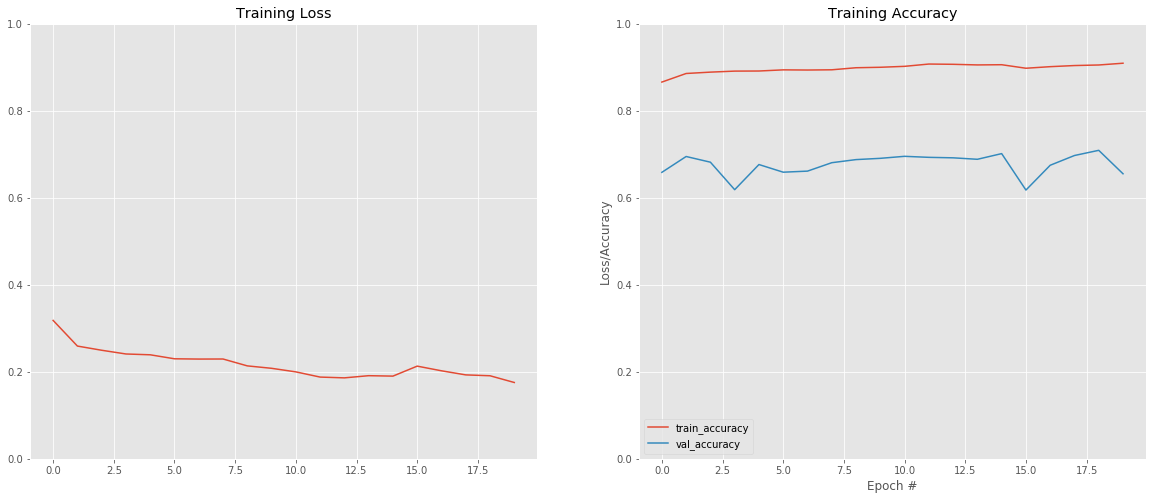

In [42]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [43]:
#training_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

In [44]:
### Extract and display model frame, prediction and mask batch

In [45]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


(5, 256, 256, 33)

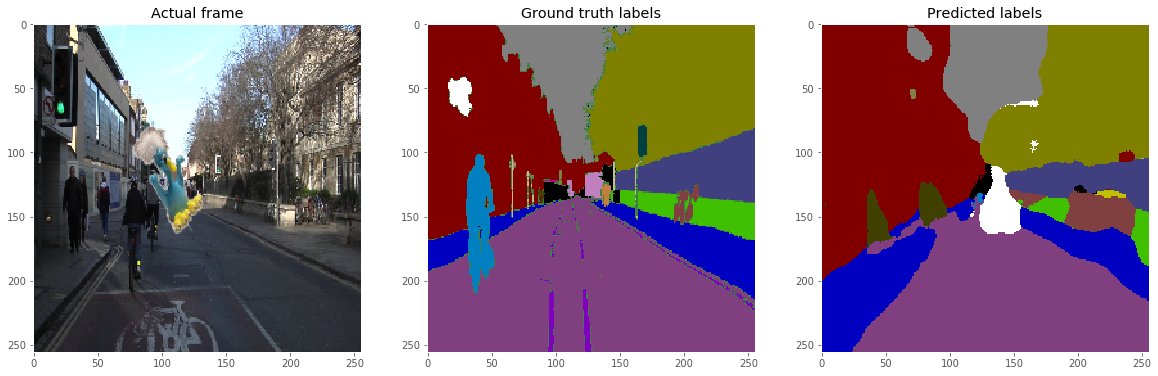

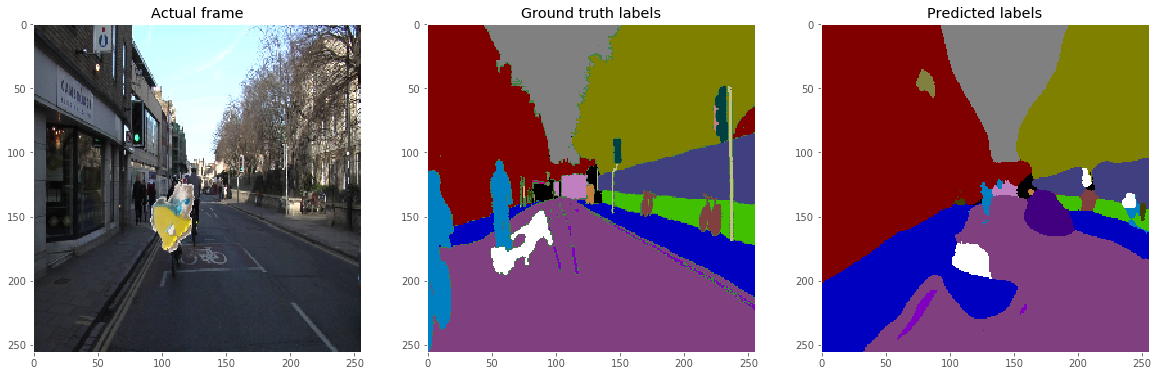

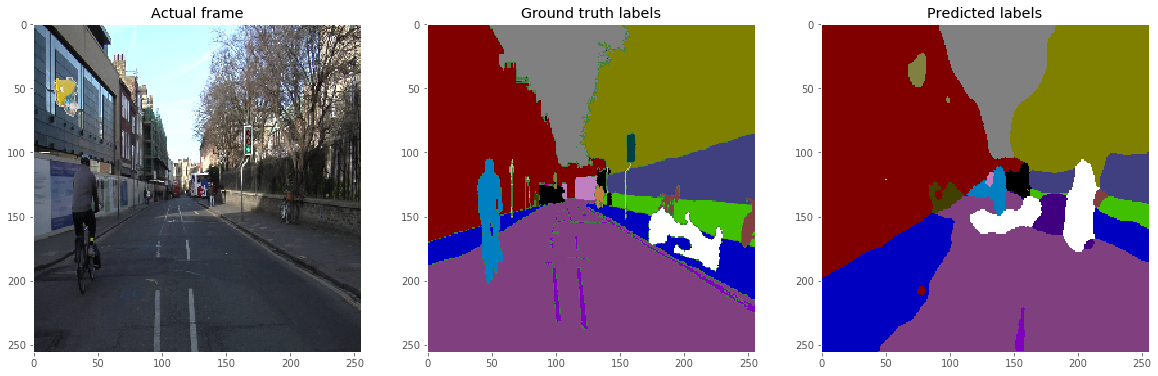

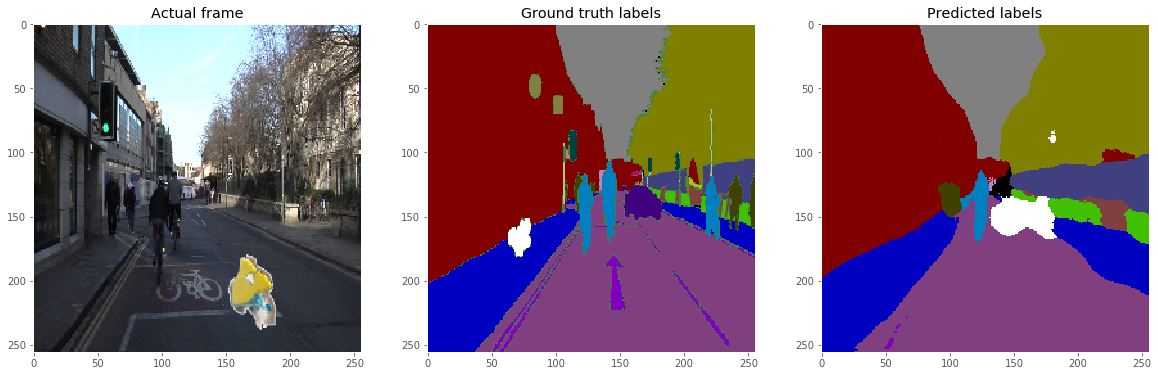

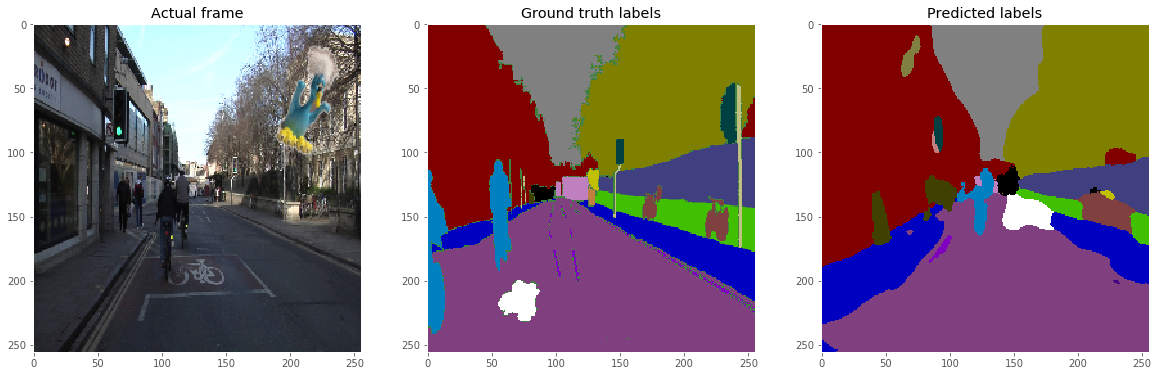

In [48]:
for i in range(0,np.shape(pred_all)[0]):

    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()